In [1165]:
import os, sys

import numpy as np
from scipy.linalg import eigh
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt
import scipy.linalg as sla
import pandas as pd
import numpy as np
from matplotlib import patches
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from astropy.io import fits
from astropy import wcs
from matplotlib import cm
from matplotlib.colors import LogNorm

In [1166]:
## This function allows to execute the OS commands
def xcmd(cmd, verbose=True):
    """Runs an OS command
    :param cmd: terminal command
    :type cmd: ``str``
    :param verbose: printing the details, default True 
    :type verbose: ``boolean``
    :return: OS outputs
    :rtype: ``str``
    """

    if verbose: print('\n'+cmd)

    tmp=os.popen(cmd)
    output=''
    for x in tmp: output+=x
    if 'abort' in output:
        failure=True
    else:
        failure=tmp.close()
    if False:
        print('execution of %s failed' % cmd)
        print('error is as follows', output)
        sys.exit()
    else:
        return output

##########################################################################

In [1167]:
def createDir(folderPath):
    """generating a directory/folder if it doesn't exist
    :param folderPath: path to the desired folder
    :type folderPath: ``str``
    :return: True is created, False if the folder already exists
    :rtype: ``str``
    """

    if not os.path.exists(folderPath):
        os.makedirs(folderPath)
        return True
    else:
        False

In [1168]:
def unit_vecort(angle):
    
    theta = angle * np.pi / 180.
    ux = np.cos(theta)
    uy = np.sin(theta)
    
    return (ux, uy)

def get_Sigma(Smajor, Sminor, angle):

    u1 = unit_vecort(angle)
    u2 = unit_vecort(angle-90)
    R = np.vstack((u1,u2))
    L = R.T
    X = np.diag((1./Smajor**2, 1./Sminor**2))
    A = np.matmul(np.matmul(L, X), R)

    return np.linalg.inv(A)

In [1169]:
def make_Ellipse(center, Smajor, Sminor, angle):
    
    Sigma = get_Sigma(Smajor, Sminor, angle)
    return [np.asarray(center), Smajor, Sminor, angle, Sigma]

def plot_Ellipse(Ell, ax=None, **kwargs):
    
    if ax is None:
        ax = plt.gca()
    
    e = patches.Ellipse(Ell[0], width=2*Ell[1], height=2*Ell[2], angle=Ell[3], **kwargs)
    ax.add_patch(e)
    
    return ax

In [1170]:
def plot_E(df, ax=None, **kwargs):
    
    Smajor = df.Rmaj
    Sminor = Smajor*(1.-df.ellip)
    
    angle = df.alpha+90
    center = (df.x0, df.y0)
    Sigma = get_Sigma(Smajor, Sminor, angle)
    Ell = make_Ellipse(center, Smajor, Sminor, angle)

    if ax is None:
        ax = plt.gca()
        
    plot_Ellipse(Ell, ax=ax, **kwargs)
    
    return ax

In [1171]:
#https://math.stackexchange.com/questions/1114879/detect-if-two-ellipses-intersect

In [1172]:
def tv(fits_file, ax=None, options=""):

    jpg_name = 'tv.jpg'

    ## Monsta script
    script = """
    rd 1 '"""+fits_file+"""'
    tv 1 """+options+""" JPEG="""+jpg_name+"""
    q

    """

    run_monsta(script, 'tv.pro', 'tv.log')
    
    xcmd("rm tv.pro & rm tv.log &", verbose=False)
    
    
    img = mpimg.imread(jpg_name)
    x_max, y_max, _ = img.shape
        
    if ax is None:
        plt.figure(figsize=(10,10))
        plt.subplot(111)
        ax = plt.gca()

    ax.set_xlim([0, x_max])
    ax.set_ylim([0, y_max])

    imgplot = ax.imshow(np.flipud(img))

    return ax

In [1173]:
def run_monsta(script, Monsta_pro, Monsta_log, monsta="/home/ehsan/Home/Monsta/bin/monsta"):
    
    with open(Monsta_pro, 'w') as f:
        f.write(script)

    cmd = monsta+' '+Monsta_pro
    xcmd(cmd + ' > '+Monsta_log, verbose=False)

    with open(Monsta_log) as f:
        text = f.read()
        if "ERROR" in text.upper().split( ):
            print(text)
            return Monsta_log
            

In [1174]:
def imOpen(inFits):
    
    hdu_list = fits.open(inFits)
    imarray = hdu_list[0].data
    header = hdu_list[0].header   
    
    return imarray, header
    

In [1175]:
def seg2mask(inFits, outMask, overwrite=True):
    
    imarray, header = imOpen(inFits)
    imarray[imarray==0] = -1
    imarray[imarray>0] = 0
    imarray[imarray==-1] = 1
    
    fits.writeto(outMask, imarray, hdr, overwrite=overwrite)
    
    return imarray

In [1176]:
class ellOBJ:
    
    x0 = 0
    y0 = 0
    a  = 1
    b  = 1
    name = ""
    R = 1        # Kron Radius
    angle = 0    # Position angle (CCW/x)
    
    catalName = "catal.dat"
    objRoot = './'
    monsta='/home/ehsan/Home/Monsta/bin/monsta'
    
    def __init__(self, name, outFolder=None):
        
        if outFolder is not None:
            createDir(outFolder)
            self.objRoot = outFolder+'/'
        
        self.name = name
        self.SExtract()
        
        hdu_list = fits.open('{}/{}j.fits'.format(name,name))
        image_data = hdu_list[0].data
        w = wcs.WCS(hdu_list[0].header)
        self.x_max, self.y_max = image_data.shape
        
        
        im, mask2 = self.backSextract()
        masked_image = im*mask2
        a = masked_image
        a = a[(a!=0)]
        self.sky_med = np.median(a)
        self.sky_ave = np.mean(a)
        self.sky_std = np.std(a)
        
    def tv_resid(self, model=0, ax=None, options="", additions=""):
        root = self.objRoot
        suffix = '.%03d'%model
        fits_file = root+'/resid'+suffix
        return self.tv(fits_file=fits_file, ax=ax, options=options, additions=additions)

    def tv_model(self, model=0, ax=None, options="", additions=""):
        root = self.objRoot
        suffix = '.%03d'%model
        fits_file = root+'/model'+suffix
        return self.tv(fits_file=fits_file, ax=ax, options=options, additions=additions)
    
    
    def tv(self, fits_file=None, ax=None, options="", additions=""):
        
        if fits_file is None:
            name = self.name
            fits_file = "{}/{}j.fits".format(name, name)
        
        root = self.objRoot
        jpg_name = root+'tv.jpg'
        
        ## Monsta script
        script = """
        rd 1 '"""+fits_file+"""'
        """+additions+"""
        tv 1 """+options+""" JPEG="""+jpg_name+"""
        q
        
        """
        
        self.run_monsta(script, root+'tv.pro', root+'tv.log')
        
        return self.plot_jpg(jpg_name, ax=ax)
        
        
        
    
    def SExtract(self):
        
        name = self.name
        root = self.objRoot
        
        catalName = root + self.catalName
        segmentation = root + 'segmentation.fits'
        
        cmd = 'sex -c wfc3j_sex.config {}/{}j.fits'.format(name,name)+' -CHECKIMAGE_TYPE SEGMENTATION -CHECKIMAGE_NAME '+segmentation+' -CATALOG_NAME ' + catalName
        
        #print(cmd)
        
        xcmd(cmd + ' > '+root+'sextractor.log', verbose=False)
        
        
        col_names = self.getColName(catalName)

        df = pd.read_csv(catalName, delimiter=r"\s+", skiprows=len(col_names), 
                         header = None, names = col_names[:18], usecols = range(18))
        
        self.x0 = df.loc[0].X_IMAGE
        self.y0 = df.loc[0].Y_IMAGE
        A  = df.loc[0].A_IMAGE
        B  = df.loc[0].B_IMAGE
        R  = df.loc[0].KRON_RADIUS
        self.angle  = df.loc[0].THETA_IMAGE
        self.a = A*R
        self.b = B*R
        self.R = R
        self.name = name
        
    
    def elliprof(self, inner_r=5, outer_r=200, sky=None, 
                 cosnx="", k=None, 
                 nr=40, niter=10,
                 model = 0, mask=None, options=""
                ):
        
        root = self.objRoot
        suffix = '.%03d'%model
        
        if sky is None:
            sky = self.sky_med
        
        if mask is None:
            maskName = './common.mask'
        else:
            maskName = root+'/mask'+'.%03d'%mask
               
        if cosnx == "":
            kosnx = ""
        else:
            if k is None:
                kosnx = cosnx+"=0"
            else:
                kosnx = cosnx+"="+str(k)
        
        
        residName = root+'/resid'+suffix
        modelName = root+'/model'+suffix
        ellipseFile = root+'/elliprof'+suffix
        objName = root+'/'+self.name+suffix
                                                                    
        elliprof_cmd = "elliprof 3  model rmstar x0="+str(self.x0)+" y0="+str(self.y0)
        elliprof_cmd += " r0="+str(inner_r)+" r1="+str(outer_r)+" nr="+str(nr)+" niter="+str(niter)+" "+kosnx
        elliprof_cmd += " "+options
        
        ## Monsta script
        script = """
        string name '"""+self.name+"""'
        rd 1 '{name}/{name}j.fits'
        sc 1 """+str(sky)+"""                            ! sky subtraction
        rd 2 """+maskName+"""
        mi 1 2
        tv 1 sqrt JPEG="""+objName+""".jpg
        cop 3 1 
        """+elliprof_cmd+"""
        print elliprof file="""+ellipseFile+"""
        cop 4 1
        si 4 3
        ac 3 """+str(sky)+"""
        mi 3 2
        mi 4 2
        wd 3 """+modelName+"""
        wd 4 """+residName+"""
        tv 4 JPEG="""+residName+""".jpg
        tv 3 JPEG="""+modelName+""".jpg
        q
        
        """
        
        Monsta_pro = root+'monsta'+suffix+'.pro'
        Monsta_log = root+'monsta'+suffix+'.log'
        
        return self.run_monsta(script, Monsta_pro, Monsta_log)
        
    def objSEextract(self, model=0, smooth=None, minArea=10, thresh=2, mask=None):
        
        root = self.objRoot
        suffix = '.%03d'%model
        
        if mask is None:
            suffix_mask = '.%03d'%model
        else:
            suffix_mask = '.%03d'%mask
        
        residName = root+'/resid'+suffix
        modelName = root+'/model'+suffix
        objName = root+'/objCheck'+suffix
        objCatal = root+'/objCatal'+suffix
        maskName = root+'/mask'+suffix_mask
        tmp = root+'/tmp'
        
        if smooth is not None:
            script = """
            rd 1 """+residName+"""
            smooth 1 fw="""+str(smooth)+"""
            wd 1 """+tmp+"""
            q
            
            """
            residName = tmp
            self.run_monsta(script, root+'obj.pro', root+'obj.log')
        
        sex_cmd = """sex """+residName+""" -c wfc3j.inpar -CHECKIMAGE_NAME """+objName
        sex_cmd += " -CATALOG_NAME  "+objCatal
        sex_cmd += " -DETECT_MINAREA "+str(minArea)
        sex_cmd += " -DETECT_THRESH "+str(thresh)
        sex_cmd += " -WEIGHT_IMAGE  "+modelName
        
        ## Monsta script
        script = """
        % """+sex_cmd+"""
        rd 1 """+objName+"""
        di 1 1
        rd 2 '"""+residName+"""'
        mi 1 2 
        cop 3 1
        di 1 1 
        wd 1 """+maskName+""" bitmap
        tv 1 JPEG="""+maskName+""".jpg
        q
        
        """       
        
        self.run_monsta(script, root+'obj'+suffix+'.pro', root+'obj'+suffix+'.log')
        
        
    def backSextract(self):
        
        name = self.name
        root = self.objRoot
        fits_name = '{}/{}j.fits'.format(name,name)
        odj_common = root+'/tmp'
        segmentation = root + 'mask2.fits'
        back = root + 'back.fits'
        
        script = """
        rd 1 """+fits_name+"""
        rd 2 ./common.mask
        mi 1 2
        wd 1 """+odj_common+"""
        q

        """
        self.run_monsta(script, root+'obj.pro', root+'obj.log')  
            
            
            
        cmd = 'sex -c wfc3j_sex.config '+odj_common
        cmd += ' -BACK_SIZE 500 -DETECT_MINAREA 4 -DETECT_THRESH 0.03 -CHECKIMAGE_TYPE "SEGMENTATION" -CHECKIMAGE_NAME '
        cmd += segmentation
              
        xcmd(cmd + ' > '+root+'sextractor.log', verbose=False)
        
        mask2 = seg2mask(segmentation, segmentation)      
        im, _ = imOpen(odj_common)

        return im, mask2
        
            
    def run_monsta(self, script, Monsta_pro, Monsta_log):

        with open(Monsta_pro, 'w') as f:
            f.write(script)

        cmd = self.monsta+' '+Monsta_pro
        xcmd(cmd + ' > '+Monsta_log, verbose=False)

        with open(Monsta_log) as f:
            text = f.read()
            Tsplit = text.upper().split( )
            if "ERROR" in Tsplit or 'SEGMENTATION FAULT' in Tsplit:
                return text
            else:
                return "OK"
            
          
    def getColName(self, catalName):
        with open(catalName, 'r') as f:

            lines = f.readlines()

        col_names = []
        i = 0 
        while lines[i].split()[0]=="#":
            col_names.append(lines[i].split()[2])   
            i+=1
            
        return col_names
    
    def set_center(self, x0, y0):
        self.x0 = x0
        self.y0 = y0
    
    def get_center(self):
        return self.x0, self.y0

    
    def plot_jpg(self, jpg_name, ax=None):
        
        img = mpimg.imread(jpg_name)
        x_max, y_max, _ = img.shape
        
        if ax is None:
            plt.figure(figsize=(10,10))
            plt.subplot(111)
            ax = plt.gca()

        ax.set_xlim([0, self.x_max])
        ax.set_ylim([0, self.y_max])

        imgplot = ax.imshow(np.flipud(img))
        
        return ax        
        
        
        
    
    
    def plot_resid(self, model=0, ax=None):   
        
        root = self.objRoot
        suffix = '.%03d'%model
        
        jpg_name = root+'/resid'+suffix+'.jpg'
        
        return self.plot_jpg(jpg_name, ax=ax)

    def plot_object(self, model=0, ax=None):   
        
        root = self.objRoot
        suffix = '.%03d'%model
        
        jpg_name = root+'/'+self.name+suffix+'.jpg'    
        
        return self.plot_jpg(jpg_name, ax=ax)
    

    def plot_ellipse(self, model=0, ax=None, **kwargs):   
        
        root = self.objRoot
        suffix = '.%03d'%model
        
        ellipseFile = root+'/elliprof'+suffix
        df = pd.read_csv(ellipseFile, delimiter=r"\s+", skiprows=7)
        df = df.apply(pd.to_numeric, errors='coerce')
       
        if ax is None:
            plt.figure(figsize=(10,10))
            plt.subplot(111)
            ax = plt.gca()
            ax.set_xlim([0, self.x_max])
            ax.set_ylim([0, self.y_max])

        for i in range(len(df)):
            plot_E(df.iloc[i], **kwargs)
        
        return ax
    
    
    def plot_background(self):   
        
        im, mask2 = self.backSextract()

        masked_image = im*mask2

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

        ## objects are masked, display background pixels
        plot_2darray(masked_image, ax=ax1)
        ax1.set_title(obj.name, fontsize=16)
        ax1.set_xlabel("X [pixel]", fontsize=14)
        ax1.set_ylabel("Y [pixel]", fontsize=14)

        a = masked_image
        a = a[(a!=0)]
        median = np.median(a)
        mean = np.mean(a)
        std = np.std(a)

        print("Back Median: %.2f"%median)
        print("Back Mean: %.2f"%mean)
        print("Back Stdev: %.2f"%std)

        ## Histogram of the potential background pixel values
        ax2.hist(a, bins=np.linspace(mean-4*std, mean+4*std, 10), density=True, color='g', alpha=0.7)
        ax2.set_xlabel("pixel value", fontsize=14)
        ax2.set_ylabel("frequency", fontsize=14)
        ax2.set_title("Background", fontsize=16)
        
        return ax1, ax2
        

In [1177]:
def plot_2darray(array, ax=None, shape=10):

    x_max, y_max = array.shape

    if ax is None:
        plt.figure(figsize=(shape, shape))
        plt.subplot(111)
        ax = plt.gca()

    ax.set_xlim([0, x_max])
    ax.set_ylim([0, y_max])

    imgplot = ax.imshow(array)

    return ax 

In [1178]:
obj = ellOBJ("n0679", outFolder="Outputs_n0679")
# obj = ellOBJ("u12517", outFolder="Outputs_u12517")
# obj = ellOBJ("n0439", outFolder="Outputs_n0439")


obj.x0, obj.y0, obj.R, obj.a, obj.b, obj.sky_med, obj.sky_ave, obj.sky_std

(564.689,
 562.985,
 3.3,
 115.65509999999999,
 93.9477,
 3442.317626953125,
 3441.1284507307864,
 119.60046454414305)

Back Median: 3442.32
Back Mean: 3441.13
Back Stdev: 119.60


(<matplotlib.axes._subplots.AxesSubplot at 0x7f6920eb32b0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6921353970>)

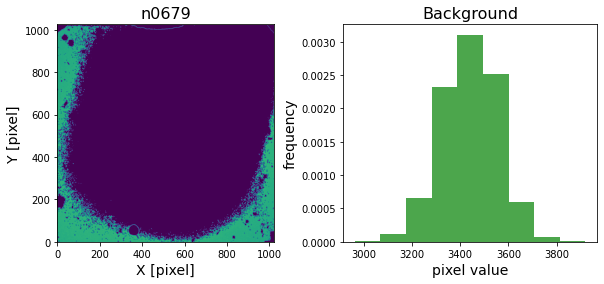

In [1179]:
obj.plot_background()

In [1195]:
%%time

r0 = 5              # pixel
c_kron = 5.0        # Kron radius factor
k = 14 
sky_factor = 0.9    # always less than one


t_indx = 100
indlst = []

for c_kron in np.arange(2.5, 5.5, 0.5):
    for sky_factor in np.arange(0.75, 1.1, 0.05):
        for r0 in range(3,11,2):
    
            r1 = int(c_kron*np.sqrt(obj.a*obj.b))
            nr = int(np.round(r1/k))
            sky = int(sky_factor*obj.sky_med)


            # generates model 0, using common mask
            if obj.elliprof(r0, r1, nr=nr, sky=sky, niter=10, options="") != 'OK':
                print("1: Err: ", t_indx, r0, r1, nr, k, sky_factor, c_kron)
                t_indx+=1
                continue
            # usese residuals of model 0, generates mask t
            obj.objSEextract(model=0, smooth=3, minArea=20, thresh=4, mask=t_indx)
            ## generates model t, uses mask t      
            if obj.elliprof(r0, r1, nr=nr, mask=t_indx, model=t_indx, niter=10, sky=sky, options="")  != 'OK':
                print("2: Err ", t_indx, r0, r1, nr, k, sky_factor, c_kron)
                t_indx+=1
                continue

        #     print(t_indx)
            indlst.append(t_indx)
            t_indx+=1


2: Err  100 3 260 19 14 0.75 2.5
2: Err  104 3 260 19 14 0.8 2.5
2: Err  108 3 260 19 14 0.8500000000000001 2.5
2: Err  112 3 260 19 14 0.9000000000000001 2.5
2: Err  116 3 260 19 14 0.9500000000000002 2.5
2: Err  120 3 260 19 14 1.0000000000000002 2.5
2: Err  128 3 260 19 14 1.1000000000000003 2.5
2: Err  132 3 312 22 14 0.75 3.0
2: Err  136 3 312 22 14 0.8 3.0
2: Err  140 3 312 22 14 0.8500000000000001 3.0
2: Err  144 3 312 22 14 0.9000000000000001 3.0
2: Err  148 3 312 22 14 0.9500000000000002 3.0
2: Err  152 3 312 22 14 1.0000000000000002 3.0
2: Err  156 3 312 22 14 1.0500000000000003 3.0
2: Err  160 3 312 22 14 1.1000000000000003 3.0
1: Err:  161 5 312 22 14 1.1000000000000003 3.0
2: Err  164 3 364 26 14 0.75 3.5
2: Err  168 3 364 26 14 0.8 3.5
2: Err  172 3 364 26 14 0.8500000000000001 3.5
2: Err  176 3 364 26 14 0.9000000000000001 3.5
2: Err  178 7 364 26 14 0.9000000000000001 3.5
2: Err  180 3 364 26 14 0.9500000000000002 3.5
2: Err  184 3 364 26 14 1.0000000000000002 3.5
2: Er

In [1196]:
print(indlst)

[101, 102, 103, 105, 106, 107, 109, 110, 111, 113, 114, 115, 117, 118, 119, 121, 122, 123, 124, 125, 126, 127, 129, 130, 131, 133, 134, 135, 137, 138, 139, 141, 142, 143, 145, 146, 147, 149, 150, 151, 153, 154, 155, 157, 158, 159, 162, 163, 165, 166, 167, 169, 170, 171, 173, 174, 175, 177, 179, 181, 182, 183, 185, 186, 187, 189, 190, 191, 193, 194, 195, 197, 198, 199, 201, 202, 203, 205, 206, 207, 209, 210, 211, 213, 214, 215, 217, 218, 219, 221, 222, 223, 225, 226, 227, 230, 231, 233, 234, 235, 237, 238, 239, 241, 242, 243, 245, 246, 247, 249, 250, 251, 253, 254, 255, 256, 257, 258, 261, 262, 263, 265, 266, 267, 269, 270, 271, 273, 274, 275, 277, 278, 279, 282, 286]


In [1197]:
def maksOpen(inMask):
    
    ## Monsta script
    script = """
    rd 1 """+inMask+"""
    wd 1 """+inMask+'.fits'+""" 
    q

    """       

    run_monsta(script, 'monsta.pro', 'monsta.log')
    xcmd("rm monsta.log; rm monsta.pro", False)
    return imOpen(inMask+'.fits')

In [1198]:
outFolder = 'Outputs_'+obj.name+'/'

CPU times: user 1.5 s, sys: 7.19 s, total: 8.69 s
Wall time: 21.4 s


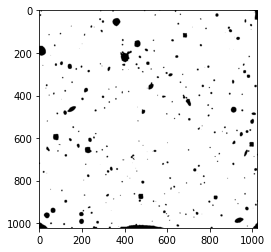

In [1209]:
%%time

IM = None
for idx in indlst:
    suffix = '.%03d'%idx
    mask_name = "mask"+suffix
    
    im, header = maksOpen(outFolder+mask_name)
    im = np.abs(im-1)
    
    if IM is None:
        IM = im
    else:
        IM = IM+im

IM /= len(indlst)
IM[IM>=0.99] = 1
IM[IM<0.99] = 0

IM = np.abs(IM-1)      
plt.imshow(IM, cmap=plt.get_cmap('gray'))


In [1216]:
fits.writeto(outFolder+'mask.super.fits', IM, header, overwrite=True)


sex n0679/n0679j.fits -c wfc3j.inpar -CHECKIMAGE_TYPE SEGMENTATION -CHECKIMAGE_NAME Outputs_n0679/segment.fits -CATALOG_NAME  Outputs_n0679/catal.cat -DETECT_MINAREA 10 -DETECT_THRESH 2 -WEIGHT_TYPE NONE


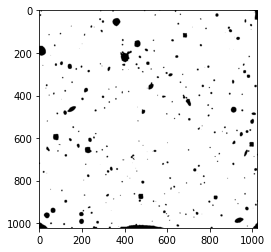

In [1221]:
name = obj.name
segment = outFolder+'segment.fits'
objCatal = outFolder+'catal.cat'
objname = "{}/{}j.fits".format(name,name)
sex_cmd = """sex """+objname+""" -c wfc3j.inpar -CHECKIMAGE_TYPE SEGMENTATION -CHECKIMAGE_NAME """+segment
sex_cmd += " -CATALOG_NAME  "+objCatal
sex_cmd += " -DETECT_MINAREA 10"
sex_cmd += " -DETECT_THRESH 2"
sex_cmd += " -WEIGHT_TYPE NONE"
xcmd(sex_cmd, True)
#######################################
im, _ = imOpen(segment)
im[im<=1] = 1
im[im>1] = 0
IM_ = IM * im
plt.imshow(IM, cmap=plt.get_cmap('gray'))
fits.writeto(outFolder+'mask.super.fits', np.float32(IM_), header, overwrite=True)

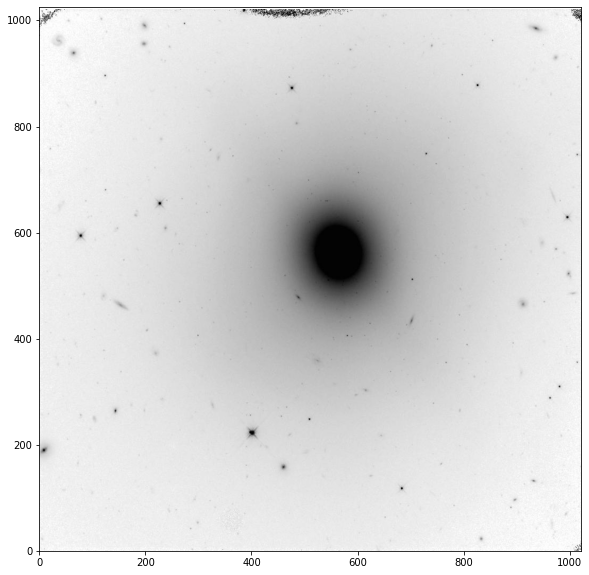

In [1201]:
obj.tv(options='sqrt')

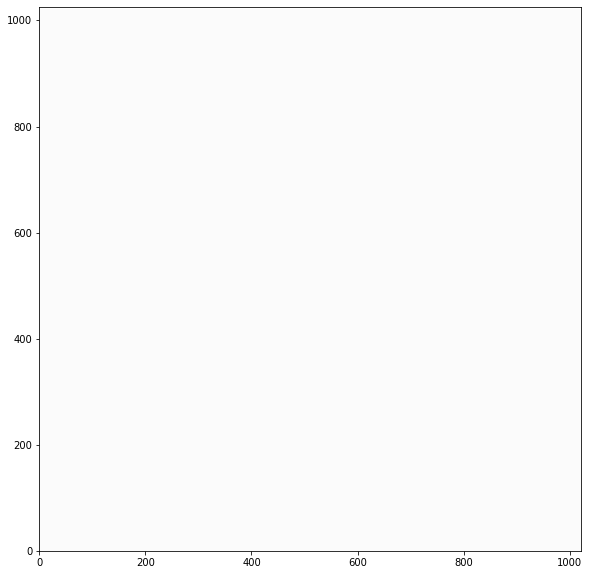

In [1202]:
tv(outFolder+'mask.super.fits', options='sqrt')

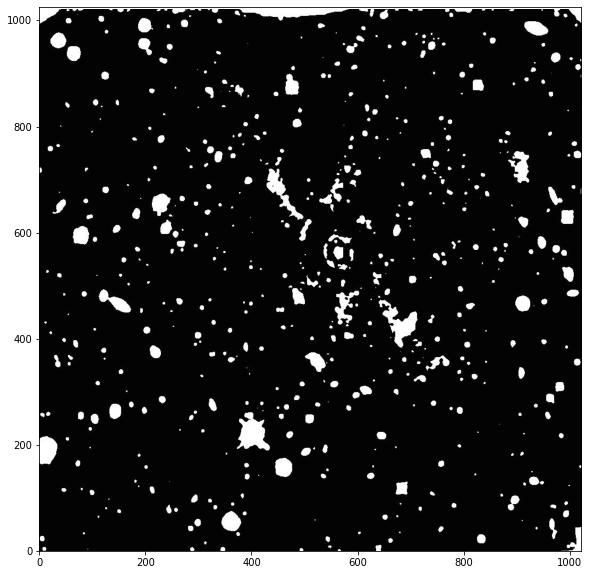

In [1150]:
mask_name = "mask.140"
ax = tv('Outputs_'+obj.name+'/'+mask_name)

416 30 3270
CPU times: user 72.1 ms, sys: 103 ms, total: 175 ms
Wall time: 1.39 s


Text(0.5, 1.0, 'n0679')

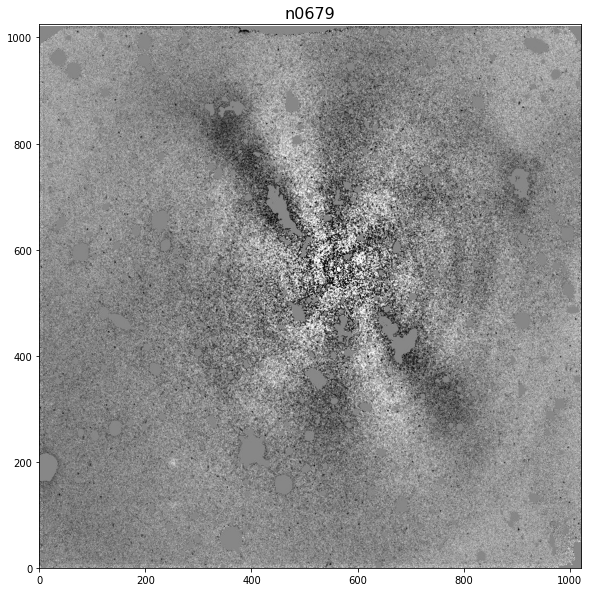

In [974]:
%%time

r0 = 5
r1 = int(4*np.sqrt(obj.a*obj.b))
nr = int(np.round(r1/14))
sky_factor = 0.95    # always less than one
sky = int(sky_factor*obj.sky_med)

print(r1, nr, sky)


# generates model 0, using common mask
obj.elliprof(r0, r1, nr=nr, sky=sky, niter=10, options="COS4X=2") 

# usese residuals of model 0, generates mask 0
obj.objSEextract(model=0, smooth=3, minArea=15, thresh=3)    

## generates model 1, uses mask 0      
obj.elliprof(r0, r1, nr=nr, mask=0, model=1, niter=10, sky=sky, options="COS4X=2")  

ax = obj.tv_resid(model=1)

# ax = obj.tv(options='sqrt cf=jt')
# Ell = make_Ellipse([obj.x0, obj.y0], obj.a, obj.b, obj.angle)
# plot_Ellipse(Ell, ax=ax, edgecolor='r', facecolor='none')

# ax = obj.plot_ellipse(model=1, ax=ax, alpha=0.5, linewidth=1, edgecolor='r', facecolor='none')



ax.set_title(obj.name, fontsize=16)

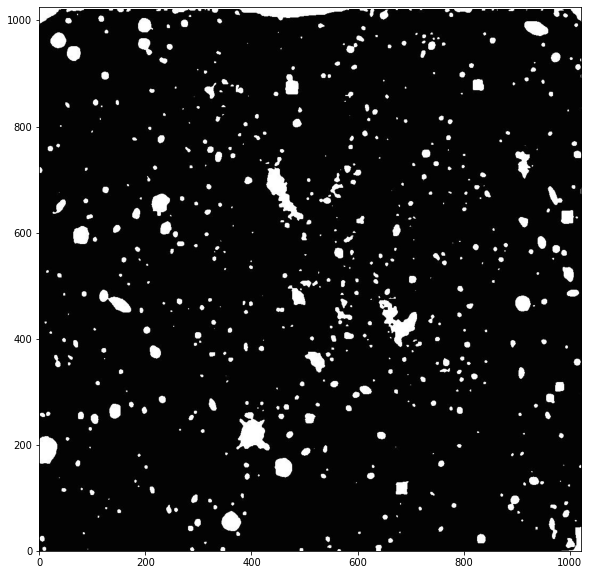

In [967]:
mask_name = "mask.000"
ax = tv('Outputs_'+obj.name+'/'+mask_name)

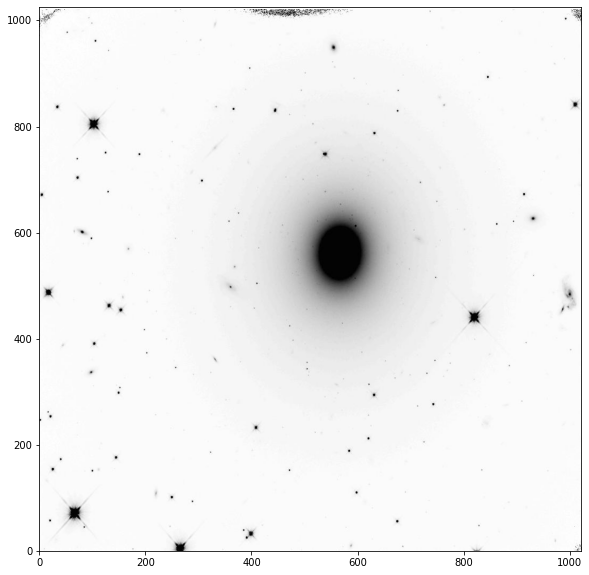

In [263]:
obj.tv(options="sqt", additions="smooth 1 fw=0")

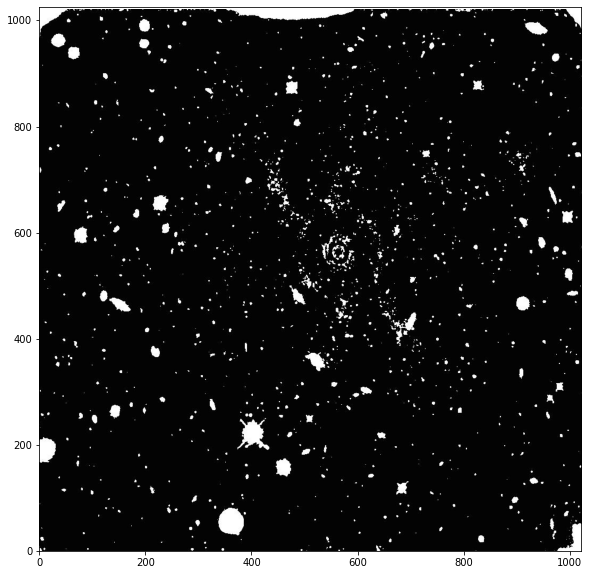

In [203]:
ax = tv('Outputs_n0679/mask.000')
# ax = obj.plot_ellipse(model=0, ax=ax, alpha=0.5, linewidth=2, edgecolor='r', facecolor='none')

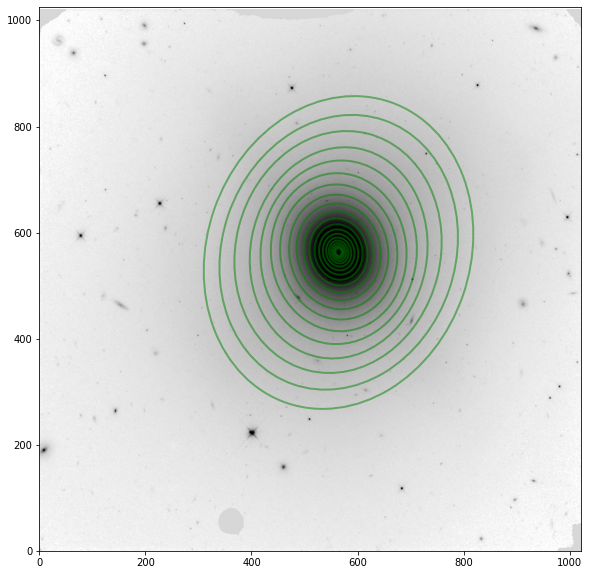

In [92]:
ax = obj.plot_object(model=0)
ax = obj.plot_ellipse(model=0, ax=ax, alpha=0.5, linewidth=2, edgecolor='g', facecolor='none')

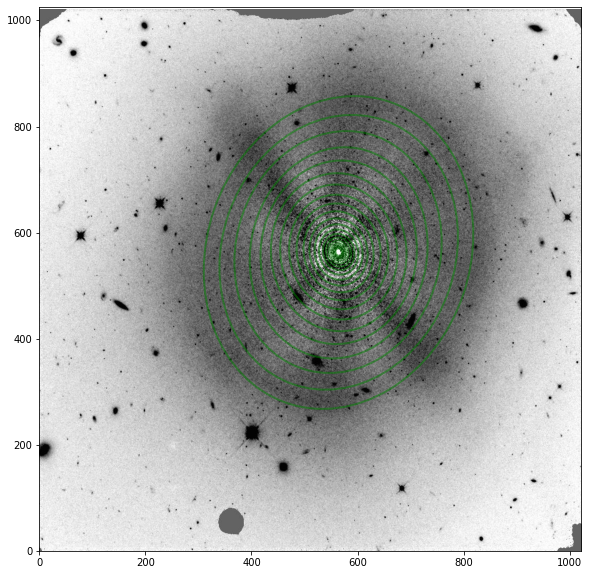

In [93]:
ax = obj.plot_resid(model=0)
ax = obj.plot_ellipse(model=0, ax=ax, alpha=0.5, linewidth=2, edgecolor='g', facecolor='none')

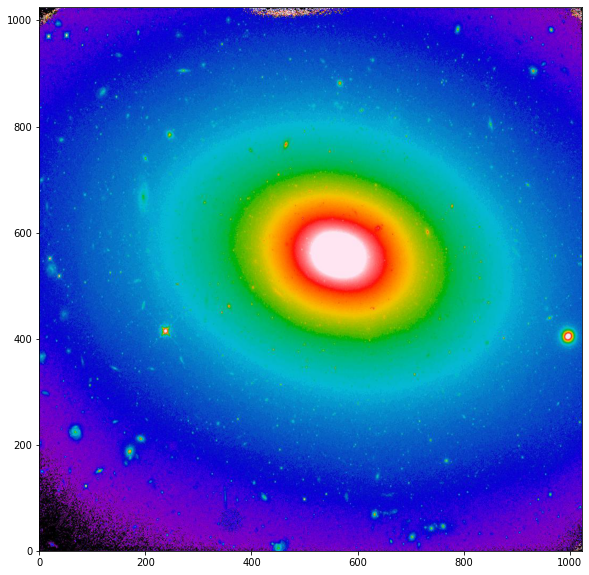

In [42]:
obj.tv(options="sqrt cf=jt")

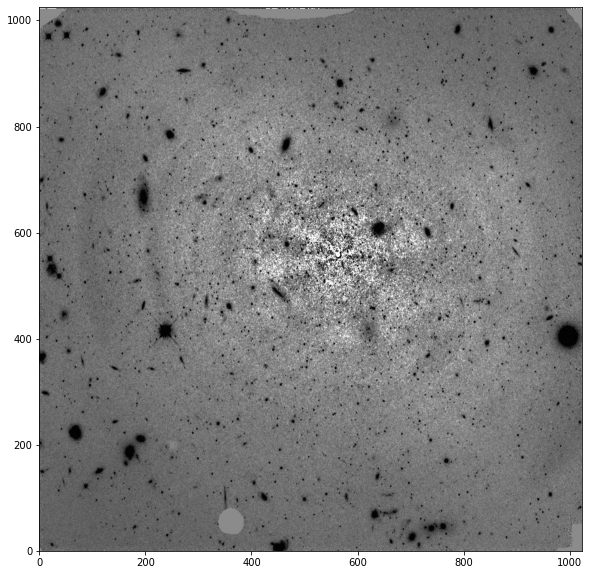

In [43]:
obj.tv_resid(model=0, options="sqrt")

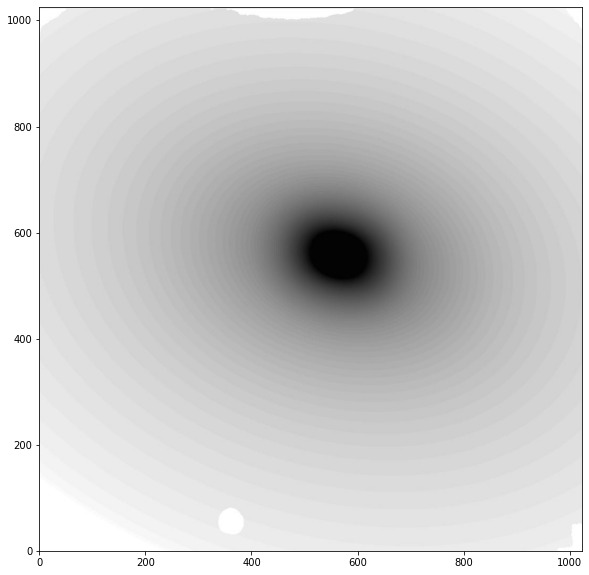

In [44]:
obj.tv_model(model=0, options="sqrt")

In [469]:
imarray.shape

(1023, 1025)